In [1]:
import os
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

In [2]:
chunk_size = 200
search_ef = 0 # 0 for default, recommend 100

if search_ef == 0:
    collection_name = f"mycollection_{chunk_size}"
else:
    collection_name = f"mycollection_{chunk_size}_ef_{search_ef}"

print(f"検索対象のコレクション名: {collection_name}")

model = "gpt-4o"
embedding_model = "text-embedding-3-large"
temperature = 0

top_k = 30

# 検索タイプ - similarity
search_type="similarity"

# 検索タイプ - similarity_score_threshold
#search_type="similarity_score_threshold"
score_threshold = 0.3

# 検索タイプ - mmr
#search_type="mmr" # for mmr
fetch_k = top_k * 2 # for mmr : Amount of documents to pass to MMR algorithm
lambda_mult = 1.0 # for mmr : 1 for minimum diversity and 0 for maximum. (Default: 0.5)


検索対象のコレクション名: mycollection_200


### LLMと埋め込みモデルの準備

In [3]:
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

# LLMの準備
llm = ChatOpenAI(
    model=model, # モデル
    temperature=temperature, # ランダムさ
)

# 埋め込みモデルの準備
embeddings = OpenAIEmbeddings(model=embedding_model)

### VectorStoreの準備

In [4]:
import chromadb
from langchain_chroma import Chroma


# Chromaクライアントを初期化
try:
    persistent_client = chromadb.PersistentClient(path="./chroma_db")

    collections = persistent_client.list_collections()
    print("現在のコレクション一覧:")
    for collection in collections:
        print(f"- {collection.name}")

    vector_store = Chroma(
        client=persistent_client,
        collection_name=collection_name,
        embedding_function=embeddings,
        collection_metadata={"hnsw:space": "ip"} 
    )
    print(f"コレクション {collection_name} のインスタンスを作成しました")

except Exception as e:
    print(f"Chromaデータベースの操作中にエラーが発生しました: {str(e)}")


現在のコレクション一覧:
- mycollection_100
- mycollection_200_ef_100
- mycollection_500_ef_100
- mycollection_1000
- mycollection_200
- mycollection_500
コレクション mycollection_200 のインスタンスを作成しました


### Retrieverの準備

In [5]:
# Retrieverの準備
if search_type == "similarity":
    retriever = vector_store.as_retriever(
        search_type=search_type,
        search_kwargs={"k": top_k}
    )
elif search_type == "similarity_score_threshold":
    retriever = vector_store.as_retriever(
        search_type=search_type,
        search_kwargs={"score_threshold": score_threshold, "k": top_k}
    )
elif search_type == "mmr":
    retriever = vector_store.as_retriever(
        search_type=search_type,
        search_kwargs={"k": top_k, "fetch_k": fetch_k, "lambda_mult": lambda_mult}
    )
else:
    raise ValueError(f"サポートされていないsearch_type: {search_type}。'similarity'または'similarity_score_threshold'を使用してください。")

### PromptTemplateの準備

In [6]:
from langchain_core.prompts import ChatPromptTemplate

# PromptTemplateの準備
prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", "あなたの仕事は、human の question に答えることです。以下の手順で回答してください。前置きや思考経過は出力しないでください。context の中の source のファイル名には、page_content の主題が含まれています。最初に、 context に書かれている情報だけを使用して、question の質問に答えることができるかどうか判断してください、判断結果は出力しません。次に、context にある情報だけで回答が可能と判断した場合は、context に書かれている情報だけを使用して、question の質問に答えてください。context にある情報だけでは回答できないと判断した場合は、情報がないので回答できないと答えてください。\n\ncontext: {context}"),
        ("human", "question: {input}"),
    ]
)

### RAGチェーンの準備

In [7]:
from langchain_core.runnables import RunnablePassthrough

# RAGチェーンの準備
rag_chain = (
    {"context": retriever, "input": RunnablePassthrough()}
    | prompt_template
    | (lambda x: print(f"\n=== Generated Prompt ===\n{x}\n========================\n") or x)  # プロンプトを表示
    | llm
)

### 質問応答

In [8]:
# テスト用の質問
query="ハグリッドがホグワーツへの入学案内書を持ってきたのはいつですか？それはどのような日でしたか？"
#query="鹿目まどかの武器は？"
# 質問応答
response = rag_chain.invoke(query)
print(f"=== LLM response ======\n{response}\n========================\n")
print(f"=== 回答 ===============\n{response.content}\n========================\n")



=== Generated Prompt ===
messages=[SystemMessage(content="あなたの仕事は、human の question に答えることです。以下の手順で回答してください。前置きや思考経過は出力しないでください。context の中の source のファイル名には、content の主題が含まれています。最初に、 context に書かれている情報だけを使用して、question の質問に答えることができるかどうか判断してください、判断結果は出力しません。次に、context にある情報だけで回答が可能と判断した場合は、context に書かれている情報だけを使用して、question の質問に答えてください。context にある情報だけでは回答できないと判断した場合は、情報がないので回答できないと答えてください。\n\ncontext: [Document(metadata={'source': 'data\\\\Wikipedia-ハリー・ポッター_(架空の人物).pdf'}, page_content='しかし、ダーズリー家は魔法に対して、かたくななまでに否定的な態度を取っており、ハリーは両親や⾃分が魔法使いであることを知らされないまま、伯⺟⼀家の冷遇と虐待を受けながら育った。1991年7⽉31⽇（ハリーの11歳の誕⽣⽇）、ホグワーツ魔法魔術学校への⼊学案内書を⼿にやってきたルビウス‧ハグリッドから⾃⾝が魔法使いであることを知らされる。そして9⽉1⽇、ホグワーツ魔法魔術学校に⼊学する[注 4]。'), Document(metadata={'source': 'data\\\\Wikipedia-ハリー・ポッター_(架空の人物).pdf'}, page_content='ホグワーツ魔法魔術学校グリフィンドール寮の男⼦⽣徒となる。孤児として⺟親の親類の伯⺟夫婦の家で不遇な暮らしをして育った。11歳を迎える年のある⽇突然、ホグワーツから⼊学許可証が届いたのをきっかけに、亡くなった両親が魔法使いであったこと、そして出⽣時に下された予⾔により、闇の魔法使いヴォルデモートを倒す宿命を⾃分が負っていると告げられる。'), Document(metadata={'source': 'data\\\\Wikipedia-ロン・ウ

## ソースつきのRAGの作成

### ソース付きRAGチェーンの準備

In [9]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

# コンテキストのフォーマット
def format_docs(docs):
    return "\n\n".join(f"{doc}" for doc in docs)


# Generationチェーンの準備
gemeration_chain = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | prompt_template
    #| (lambda x: print(f"\n=== Generated Prompt ===\n{x}") or x)  # プロンプトを表示
    | llm
    | StrOutputParser()
)

# Retrieverチェーンの準備
retrieve_chain = (lambda x: x["input"]) | retriever

# ソース付きRAGチェーンの準備
rag_chain_with_source = RunnablePassthrough.assign(context=retrieve_chain).assign(
    answer=gemeration_chain
)

### 質問応答

In [10]:
# 質問応答の結果を見やすくフォーマットする関数
def format_rag_response(response):
    print("質問:", response["input"])
    print("\n回答:", response["answer"])
    print("\n参照コンテキスト:")
    for i, doc in enumerate(response["context"], 1):
        print(f"\n--- ドキュメント {i} ---")
        print(f"ソース: {doc.metadata['source']}")
        print(f"文字数: {len(doc.page_content)}")
        print(f"内容: {doc.page_content[:1000]}...")  # 長すぎる場合は省略

# 質問応答
response = rag_chain_with_source.invoke({"input": query})
format_rag_response(response)
#print(response)


質問: ハグリッドがホグワーツへの入学案内書を持ってきたのはいつですか？それはどのような日でしたか？

回答: 1991年7月31日、ハリーの11歳の誕生日に、ハグリッドがホグワーツへの入学案内書を持ってきました。

参照コンテキスト:

--- ドキュメント 1 ---
ソース: data\Wikipedia-ハリー・ポッター_(架空の人物).pdf
文字数: 199
内容: しかし、ダーズリー家は魔法に対して、かたくななまでに否定的な態度を取っており、ハリーは両親や⾃分が魔法使いであることを知らされないまま、伯⺟⼀家の冷遇と虐待を受けながら育った。1991年7⽉31⽇（ハリーの11歳の誕⽣⽇）、ホグワーツ魔法魔術学校への⼊学案内書を⼿にやってきたルビウス‧ハグリッドから⾃⾝が魔法使いであることを知らされる。そして9⽉1⽇、ホグワーツ魔法魔術学校に⼊学する[注 4]。...

--- ドキュメント 2 ---
ソース: data\Wikipedia-ハリー・ポッター_(架空の人物).pdf
文字数: 169
内容: ホグワーツ魔法魔術学校グリフィンドール寮の男⼦⽣徒となる。孤児として⺟親の親類の伯⺟夫婦の家で不遇な暮らしをして育った。11歳を迎える年のある⽇突然、ホグワーツから⼊学許可証が届いたのをきっかけに、亡くなった両親が魔法使いであったこと、そして出⽣時に下された予⾔により、闇の魔法使いヴォルデモートを倒す宿命を⾃分が負っていると告げられる。...

--- ドキュメント 3 ---
ソース: data\Wikipedia-ロン・ウィーズリー.pdf
文字数: 125
内容: その後、ホグワーツ魔法魔術学校に⼊学し、ハリー同様グリフィンドール寮⽣となる。種族性別家族1992年夏、ハリーを⾃宅に迎えるため、⽗の所有するフォード‧アングリアを借りて、フレッド、ジョージとともにダーズリー家を訪問。軟禁されていたハリーを救出する。...

--- ドキュメント 4 ---
ソース: data\Wikipedia-ロン・ウィーズリー.pdf
文字数: 111
内容: 軟禁されていたハリーを救出する。同年9⽉1⽇にはドビーによりホグワーツ特急に乗⾞できなかったため、ふたたびフォード‧アングリアを借りてハリーとともにホグワーツへ向かうが、ホグワーツ到着時に暴れ柳から攻撃を

## RAGASによる評価


### 評価用 LLM と埋め込みモデルの準備

In [11]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_core.outputs import LLMResult
def my_finished_parser(response: LLMResult) -> bool:
    #print(response)
    return True
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini", openai_api_key=os.getenv("OPENAI_API_KEY")), is_finished_parser=my_finished_parser)
#evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini", openai_api_key=os.getenv("OPENAI_API_KEY")))
evaluator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model="text-embedding-3-small", openai_api_key=os.getenv("OPENAI_API_KEY")))

### 質問・正解・コンテキスト・回答の準備

In [12]:
# 質問
question = [
    "高町なのはがユーノから譲り受けたものは何ですか？",
    "高町なのはには兄弟姉妹はいますか？名前はわかりますか？",
    "高町なのはは、フェイトのことをどのように呼んでいますか？",
    "四葉家の次期当主候補は誰ですか？",
    "時空管理局のアースラの艦長は誰ですか？",
    "ユーノ・スクライアは、普段どのような動物の姿で過ごしていますか？",
    "フェイト・テスタロッサのデバイス（魔法の杖）の名前は？",
    "高町なのはが小学生のときに通っていた学校は？",
    "高町なのはとユーノが回収しようとしているものは何？？",
    "死の秘宝のひとつで、ダウンブルドアからハリーに渡されたものは何ですか？",
    "魔法少女リリカルなのはの主人公は？",
    "魔法少女まどか☆マギカの主人公の名前は？",
    "鹿目まどかの声は誰が担当していますか？",
    "魔法少女まどか☆マギカの映画「[新編]反逆の物語」の政党続編となる新作映画は？",
    "リリカルなのはで、自立判断し英語でしゃべるパートナーとして描かれているものは何ですか？",
    "聖王のゆりかごとは何ですか、どのくらいの大きさですか？",
    "スターライトブレイカーは誰のどのような魔法ですか？",
    "ニュータイプアニメアワード2011では女性キャラクター賞で1位を獲得したキャラクターは？",
    "レリックの発掘と同時に現れた謎の機械兵器群は何ですか？",
    "ハグリッドがホグワーツへの入学案内書を持ってきたのはいつですか？それはどのような日でしたか？"
]

# 正解
ground_truth = [
    "高町なのはがユーノから譲り受けたものはインテリジェントデバイスのレイジングハートです",
    "高町なのはには、兄の恭也と姉の美由希がいます。",
    "高町なのはは、フェイトのことを公の場では「フェイト隊長」と呼ぶこともあるが、プライベートでは「フェイトちゃん」と呼んでいます。",
    "四葉家の次期当主候補は司波深雪です。",
    "時空管理局のアースラの艦長は、リンディ・ハラオウンです。",
    "ユーノ・スクライアは、普段フェレットのような動物の姿で過ごしています。",
    "フェイト・テスタロッサののデバイス（魔法の杖）の名前はバルディッシュです。",
    "高町なのはが小学生のときに通っていた学校は、私立聖祥大附属小学校です。",
    "高町なのはとユーノが回収しようとしているものはジュエルシードです。",
    "死の秘宝のひとつで、ダウンブルドアからハリーに渡されたものは透明マントです。",
    "魔法少女リリカルなのはの主人公は、高町なのはです。",
    "魔法少女まどか☆マギカの主人公の名前は、鹿目まどかです。",
    "鹿目まどかの声は、悠木碧（ゆうき あおい）が担当しています。",
    "魔法少女まどか☆マギカの映画「[新編]反逆の物語」の正統続編となる新作映画は『劇場版 魔法少女まどか☆マギカ〈ワルプルギスの廻天〉』です。",
    "魔法少女リリカルなのはで、自立判断し英語でしゃべるパートナーとして描かれているものは、「魔法の杖」です。",
    "聖王のゆりかごとは、古代ベルカの遺産の一つ。その正体は旧暦において一度は世界を滅ぼしたとされる強大な質量兵器で、全長数kmの巨大飛行戦艦です。",
    "スターライトブレイカーは、なのは最大最強の切り札であり、彼女の代名詞ともなっている魔法。なのは本人（+カートリッジ）の魔力に加えて、なのは個人の希少スキル「魔力収束」をもって戦場に漂う残留魔力をも呼び集めて特大の一撃を放つ集束砲撃魔法です。",
    "ニュータイプアニメアワード2011では女性キャラクター賞で1位を獲得したキャラクターは、暁美ほむらです。",
    "レリックの発掘と同時に現れた謎の機械兵器群は、ガジェット・ドローンです。",
    "ハグリッドがホグワーツへの入学案内書を持ってきたのは、ハリーの11歳の誕生日の1991年7月31日です。"
]

# コンテキストと回答の生成
contexts = []
answer = []
for q in question:
    print("質問:", q)
    response = rag_chain_with_source.invoke({"input": q})
    contexts.append([x.page_content for x in response["context"]])
    print(f"回答: {response['answer']}\n")
    answer.append(response["answer"])

#print("contexts:", contexts)
#print("answer:", answer)

質問: 高町なのはがユーノから譲り受けたものは何ですか？
回答: インテリジェントデバイス「レイジングハート」です。

質問: 高町なのはには兄弟姉妹はいますか？名前はわかりますか？
回答: 高町なのはには兄と姉がいます。兄の名前は恭也、姉の名前は美由希です。

質問: 高町なのはは、フェイトのことをどのように呼んでいますか？
回答: 高町なのはは、フェイトのことを「フェイトちゃん」と呼んでいます。

質問: 四葉家の次期当主候補は誰ですか？
回答: 四葉家の次期当主候補は深雪です。

質問: 時空管理局のアースラの艦長は誰ですか？
回答: リンディ・ハラオウンです。

質問: ユーノ・スクライアは、普段どのような動物の姿で過ごしていますか？
回答: ユーノ・スクライアは、普段フェレットに似た動物の姿で過ごしています。

質問: フェイト・テスタロッサのデバイス（魔法の杖）の名前は？
回答: フェイト・テスタロッサのデバイス（魔法の杖）の名前は「バルディッシュ」です。

質問: 高町なのはが小学生のときに通っていた学校は？
回答: 高町なのはが小学生のときに通っていた学校は、私立聖祥大附属小学校です。

質問: 高町なのはとユーノが回収しようとしているものは何？？
回答: ジュエルシードです。

質問: 死の秘宝のひとつで、ダウンブルドアからハリーに渡されたものは何ですか？
回答: 透明マントです。

質問: 魔法少女リリカルなのはの主人公は？
回答: 魔法少女リリカルなのはの主人公は、高町なのはです。

質問: 魔法少女まどか☆マギカの主人公の名前は？
回答: 鹿目まどかです。

質問: 鹿目まどかの声は誰が担当していますか？
回答: 鹿目まどかの声は悠木碧が担当しています。

質問: 魔法少女まどか☆マギカの映画「[新編]反逆の物語」の政党続編となる新作映画は？
回答: 『劇場版 魔法少女まどか☆マギカ〈ワルプルギスの廻天〉』です。

質問: リリカルなのはで、自立判断し英語でしゃべるパートナーとして描かれているものは何ですか？
回答: 魔法の杖です。

質問: 聖王のゆりかごとは何ですか、どのくらいの大きさですか？
回答: 聖王のゆりかごは、古代ベルカの遺産の一つで、その正体は旧暦において一度は世界を滅ぼしたとされる強大な質量兵器です。全長数kmの巨大飛行戦艦

### データセットの準備

In [13]:
from datasets import Dataset 

# データセットの準備
ds = Dataset.from_dict(
    {
        "question": question,
        "answer": answer,
        "contexts": contexts,
        "ground_truth": ground_truth,
    }
)

In [14]:
import os
import json
from datetime import datetime
import glob

# logディレクトリの作成（存在しない場合）
os.makedirs("log", exist_ok=True)

# 基本ファイル名の作成
base_filename = f"rag_eval_chunk{chunk_size}_top{top_k}_{search_type}"

# 既存ファイルをチェックして番号を決定
existing_files = glob.glob(f"log/{base_filename}*.json")
file_num = len(existing_files)
filename = f"log/{base_filename}_{file_num}.json" if file_num > 0 else f"log/{base_filename}.json"

# 保存するデータの準備
save_data = {
    "metadata": {
        "Collection": collection_name,
        "model": model,
        "temperature": temperature,
        "embedding_model": embedding_model,
        "chunk_size": chunk_size,
        "search_ef": search_ef,
        "top_k": top_k,
        "search_type": search_type,
        "score_threshold": score_threshold,
        "fetch_k": fetch_k,
        "lambda_mult": lambda_mult,
        "timestamp": datetime.now().isoformat()
    },
    "evaluation_data": {
        "questions": question,
        "answers": answer,
        "contexts": contexts,
        "ground_truths": ground_truth
    }
}

# JSONファイルとして保存
with open(filename, "w", encoding="utf-8-sig") as f:
    json.dump(save_data, f, ensure_ascii=False, indent=2)

print(f"データを {filename} に保存しました。")

データを log/rag_eval_chunk200_top30_similarity.json に保存しました。


In [15]:
from ragas import evaluate
from ragas.metrics import Faithfulness, AnswerRelevancy, ContextPrecision, ContextRecall

metrics = [
    Faithfulness(llm=evaluator_llm),
    AnswerRelevancy(llm=evaluator_llm, embeddings=evaluator_embeddings),
    ContextPrecision(llm=evaluator_llm),
    ContextRecall(llm=evaluator_llm)
]

# 評価の実行
result = evaluate(
    dataset=ds,
    metrics=metrics
)
print(result)

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

{'faithfulness': 0.8500, 'answer_relevancy': 0.4156, 'context_precision': 0.5187, 'context_recall': 0.9500}


In [16]:
import matplotlib.pyplot as plt
import math
import csv

plt.rcParams['font.family'] = 'MS Gothic'

# 結果データの準備
Faithfulness_avr = math.floor(sum(result['faithfulness'])/len(result['faithfulness']) * 1000) / 1000
AnswerRelevancy_avr = math.floor(sum(result['answer_relevancy'])/len(result['answer_relevancy']) * 1000) / 1000
ContextPrecision_avr = math.floor(sum(result['context_precision'])/len(result['context_precision']) * 1000) / 1000
context_recall_avr = math.floor(sum(result['context_recall'])/len(result['context_recall']) * 1000) / 1000

# ファイル名の作成
csv_filename = f"log/{base_filename}_{file_num}_metrics.csv" if file_num > 0 else f"log/{base_filename}_metrics.csv"

# CSVファイルに書き出し
with open(csv_filename, 'w', newline='', encoding='utf-8-sig') as f:
    writer = csv.writer(f)
    
    # ヘッダーの書き出し
    writer.writerow(['Question', 'Answer', 'Ground Truth', 'Faithfulness', 'Answer Relevancy', 'Context Precision', 'Context Recall'])
    
    # 各テストケースの結果を書き出し
    for i, (q, a, gt) in enumerate(zip(question, answer, ground_truth)):
        writer.writerow([
            q,
            a,
            gt,
            result['faithfulness'][i],
            result['answer_relevancy'][i],
            result['context_precision'][i],
            result['context_recall'][i]
        ])
    
    # 平均値の書き出し
    writer.writerow([
        'Average',
        '',  # Answer列は空欄
        '',  # Ground Truth列は空欄
        Faithfulness_avr,
        AnswerRelevancy_avr,
        ContextPrecision_avr,
        context_recall_avr
    ])

print(f"評価結果を {csv_filename} に保存しました。")

評価結果を log/rag_eval_chunk200_top30_similarity_metrics.csv に保存しました。


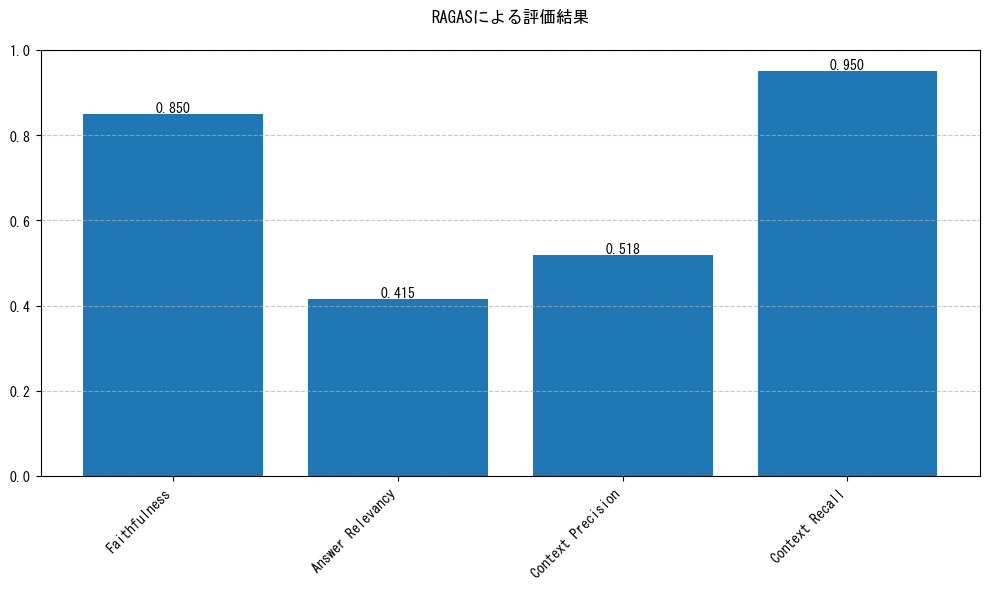

: 

In [17]:
metrics_data = {
    'Faithfulness': Faithfulness_avr,
    'Answer Relevancy': AnswerRelevancy_avr,
    'Context Precision': ContextPrecision_avr,
    'Context Recall': context_recall_avr
}

# プロットの作成
plt.figure(figsize=(10, 6))
bars = plt.bar(list(metrics_data.keys()), list(metrics_data.values()))

# グラフの装飾
plt.title('RAGASによる評価結果', pad=20)
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 数値を棒グラフの上に表示
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.savefig(f"log/{base_filename}_{file_num}_metrics.png" if file_num > 0 else f"log/{base_filename}_metrics.png", 
            dpi=300,  # 解像度
            bbox_inches='tight'  # 余白を自動調整
           )
plt.show()